In [1]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import hvplot as hv
import hvplot.pandas
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))  # parent of notebooks
if project_root not in sys.path:
    sys.path.append(project_root)
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from src.util.model import eval_model, prep_data
seed = 42

In [2]:
dff0 = pd.DataFrame()

data_fp = "../../data/training_data"
for fn in os.listdir(data_fp):
    df = pd.read_csv(os.path.join(data_fp, fn))
    print(f"{fn} {df.shape}")
    dff0 = pd.concat([dff0, df])
print(dff0.shape)

snow_2020-2025_p134_fxx1.csv (116216, 68)
snow_2020-2025_p198_fxx1.csv (145920, 68)
snow_2020-2025_p192_fxx1.csv (145920, 68)
snow_2020-2025_p193_fxx1.csv (145920, 68)
snow_2020-2025_p202_fxx1.csv (145920, 68)
snow_2020-2025_p153_fxx1.csv (145920, 68)
snow_2020-2025_p182_fxx1.csv (145920, 68)
snow_2020-2025_p183_fxx1.csv (145920, 68)
snow_2020-2025_p186_fxx1.csv (145920, 68)
snow_2020-2025_p121_fxx1.csv (145920, 68)
snow_2020-2025_p207_fxx1.csv (145920, 68)
snow_2020-2025_p206_fxx1.csv (145920, 68)
snow_2020-2025_p105_fxx1.csv (145920, 68)
snow_2020-2025_p200_fxx1.csv (145920, 68)
snow_2020-2025_p119_fxx1.csv (145920, 68)
snow_2020-2025_p151_fxx1.csv (145920, 68)
(2305016, 68)


In [3]:
danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])
danger_levels = danger_levels[danger_levels['lower'] > -1]
danger_levels = danger_levels.drop_duplicates()
print(danger_levels.shape)
print(danger_levels.head())

(4033, 7)
        date     id  danger_rating forecast_zone_id  lower  upper  middle
0 2020-10-19  90469              0         flathead      0      0       0
1 2020-10-20  90469              0         flathead      0      0       0
2 2020-10-21  90469              0         flathead      0      0       0
3 2020-10-22  90469              0         flathead      0      0       0
4 2020-10-23  90469              0         flathead      0      0       0


In [4]:
X, y = prep_data(
    dff0, 
    danger_levels, 
    replace_missing=True, 
    change_danger=True,
    exclude_cols=['date','id','slope_azi', 'danger_level','altitude','slope_angle']) 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)

In [5]:
rf = RandomForestClassifier(random_state=seed, 
                            n_estimators=100, 
                            max_depth=50, 
                            class_weight="balanced",
                            min_samples_split=10,
                            min_samples_leaf=2)

rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,50
,min_samples_split,10
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Train
Accuracy 0.86
MSE: 0.16940907460545193
RMSE: 0.4115933364444229
MAE: 0.14900914634146342
Test
Accuracy 0.78
MSE: 0.2638736335582405
RMSE: 0.5136863182509736
MAE: 0.23447879073173283


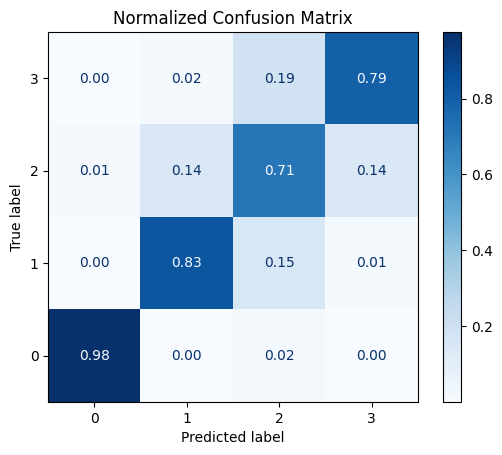

In [6]:
y_pred = rf.predict(X_test)

print("Train")
eval_model(y_train, rf.predict(X_train))

print("Test")
eval_model(y_test, y_pred, plot=True, norm=True)

In [7]:
feature_importances = pd.DataFrame(rf.feature_importances_,index = X_train.columns, columns=["importance"]).sort_values(by="importance", ascending=False)
print(feature_importances[feature_importances['importance'] > 0])

                      importance
mAlbedo                 0.065657
ISWR_diff               0.041987
HN72_24                 0.034685
TA                      0.032440
SWE                     0.030460
HS_mod                  0.029644
MS_Water                0.026853
ISWR_h                  0.025442
wind_trans24            0.023388
ISWR                    0.022424
ColdContentSnow         0.021768
ISWR_dir                0.021363
S5                      0.020983
zSs                     0.020882
HS_meas                 0.020310
RH                      0.020151
zS4                     0.019887
ski_pen                 0.019729
zSn                     0.018431
OSWR                    0.018143
pAlbedo                 0.017599
TSG                     0.017503
PSUM24                  0.017284
dIntEnergySnow          0.017277
TSS_mod                 0.017218
OLWR                    0.016540
S4                      0.015975
VW_drift                0.015972
Ss                      0.015782
T_bottom  